In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import os

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import numpy as np

import random

from typing import List , Dict , Tuple

In [ ]:
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
    transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    transforms.ToTensor() ,
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)
])

In [ ]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=data_transform,
    target_transform=None
)


test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=data_transform
)

100%|██████████| 170498071/170498071 [00:03<00:00, 47589844.35it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
class_names = train_data.classes

class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

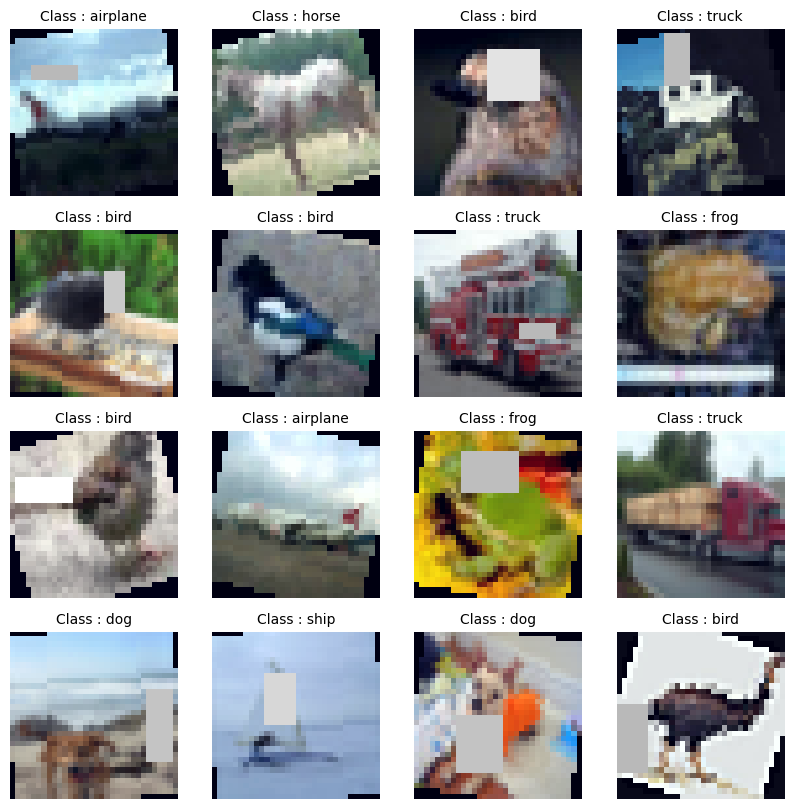

In [ ]:
rand_idx = random.sample(range(len(train_data)),k=16)

plt.figure(figsize=(10,10))

for i , idx in enumerate(rand_idx):

  img , label = train_data[idx]

  img = (img - img.min()) / (img.max() - img.min())

  img_class = class_names[label]

  plt.subplot(4,4,i+1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"Class : {img_class}",fontsize=10)
  plt.axis(False)

In [ ]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 800

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

In [ ]:
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               scheduler:torch.optim.lr_scheduler = None,
               grad_clip:float=None):

  model.train()

  train_loss , train_acc = 0 , 0

  for batch , (X,y) in enumerate(dataloader):

    X , y = X.to(device) , y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()

    if grad_clip:
      nn.utils.clip_grad_value_(model.parameters(), grad_clip)

    optimizer.step()
    y_pred_class = torch.argmax(y_pred,dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  if scheduler is not None:
    scheduler.step(train_loss)


  return train_loss , train_acc

In [ ]:
def test_step(model:nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module):

  model.eval()

  test_loss , test_acc = 0 , 0

  with torch.inference_mode():
    for batch , (X,y) in enumerate(dataloader):
      X , y = X.to(device) , y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()
      test_pred_labels = torch.argmax(test_pred_logits,dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss , test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler:torch.optim.lr_scheduler,
          grad_clip:float=None,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler,
                                           grad_clip=grad_clip)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):


    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

In [ ]:
class ResNet9(nn.Module):
    def conv_block(self, input_channels, output_channels, use_pool=False):
        layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                  nn.BatchNorm2d(output_channels),
                  nn.ReLU(inplace=True)]
        if use_pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def __init__(self, input_channels, number_classes):
        super().__init__()

        self.conv1 = self.conv_block(input_channels, 64)
        self.conv2 = self.conv_block(64, 128, use_pool=True)
        self.residual1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))

        self.conv3 = self.conv_block(128, 256, use_pool=True)
        self.conv4 = self.conv_block(256, 512, use_pool=True)
        self.residual2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, number_classes))

    def forward(self, xb):
        layer1 = self.conv1(xb)
        layer2 = self.conv2(layer1)
        residual1 = self.residual1(layer2) + layer2
        layer3 = self.conv3(residual1)
        layer4 = self.conv4(layer3)
        residual2 = self.residual2(layer4) + layer4
        class_output = self.classifier(residual2)
        return class_output

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
NUM_EPOCHS = 30
learning_rate = 0.001

weight_decay = 35e-5
grad_clip = 0.0001

model_2 = ResNet9(3,10).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2.parameters(),lr=learning_rate,weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',verbose=True,factor=0.3,patience=3,threshold=0.09)


from timeit import default_timer as timer
start_time = timer()


model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        grad_clip=grad_clip,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6191 | train_acc: 0.4499 | test_loss: 1.2889 | test_acc: 0.5386
Epoch: 2 | train_loss: 1.0605 | train_acc: 0.6230 | test_loss: 1.1944 | test_acc: 0.5641
Epoch: 3 | train_loss: 0.8858 | train_acc: 0.6881 | test_loss: 1.1469 | test_acc: 0.5984
Epoch: 4 | train_loss: 0.7914 | train_acc: 0.7262 | test_loss: 1.0315 | test_acc: 0.6396
Epoch: 5 | train_loss: 0.7253 | train_acc: 0.7511 | test_loss: 0.9983 | test_acc: 0.6426
Epoch: 6 | train_loss: 0.6787 | train_acc: 0.7685 | test_loss: 0.9791 | test_acc: 0.6690
Epoch: 7 | train_loss: 0.6484 | train_acc: 0.7789 | test_loss: 1.0704 | test_acc: 0.6278
Epoch: 8 | train_loss: 0.6300 | train_acc: 0.7852 | test_loss: 1.0188 | test_acc: 0.6399
Epoch: 9 | train_loss: 0.6113 | train_acc: 0.7931 | test_loss: 0.8787 | test_acc: 0.7031
Epoch: 10 | train_loss: 0.5985 | train_acc: 0.7977 | test_loss: 0.8914 | test_acc: 0.6976
Epoch: 11 | train_loss: 0.5984 | train_acc: 0.7971 | test_loss: 1.3348 | test_acc: 0.5675
Epoch: 12 | train_l

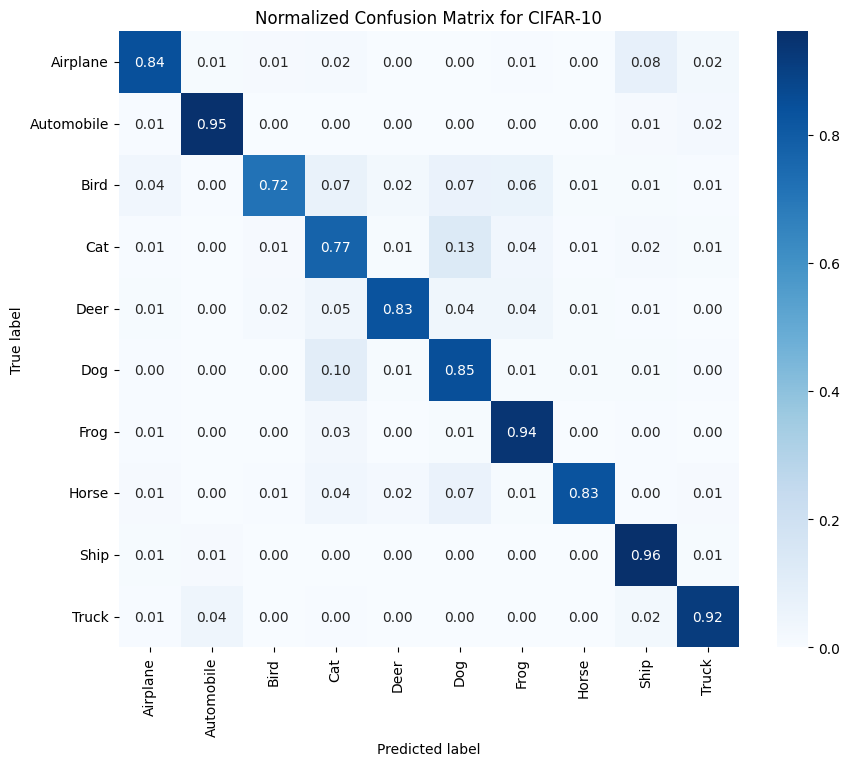

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck"
]

def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

labels, preds = get_predictions(model_2, test_dataloader, device)

cm = confusion_matrix(labels, preds)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix for CIFAR-10')
plt.show()


# **Unlearning**

# **Doing for target class airplane and cat**

Files already downloaded and verified
Files already downloaded and verified


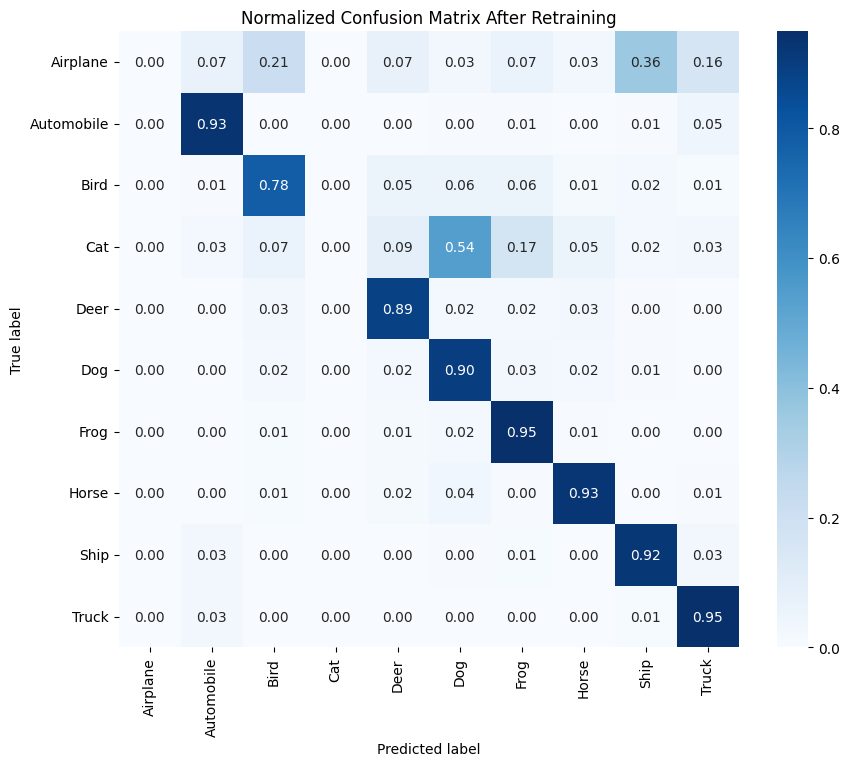

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# CIFAR-10 class names
class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck"
]

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

forget_classes = [0, 3]  # Airplane and Cat
retain_classes = [1, 2, 4, 5, 6, 7, 8, 9]

forget_mask = np.isin(trainset.targets, forget_classes)
retain_mask = ~forget_mask

forget_set = Subset(trainset, np.where(forget_mask)[0])
retain_set = Subset(trainset, np.where(retain_mask)[0])

forget_loader = DataLoader(forget_set, batch_size=128, shuffle=True)
retain_loader = DataLoader(retain_set, batch_size=128, shuffle=True)

NUM_EPOCHS = 30
learning_rate = 0.001
weight_decay = 35e-5
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate, weight_decay=weight_decay)

def train(model, dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

train(model_2, retain_loader, optimizer, NUM_EPOCHS)

def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

labels, preds = get_predictions(model_2, DataLoader(testset, batch_size=128, shuffle=False), device)

cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix After Retraining')
plt.show()
